<a href="https://colab.research.google.com/github/velasoka-repo/EVA4/blob/master/Session-9/EVA4_S9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Github Link](https://github.com/velasoka-repo/EVA4/tree/master/Session-9)

# Google Drive Mount

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
EVA4_PATH = "/content/gdrive/My Drive/Colab Notebooks/EVA4/Session-9"
import sys
if not EVA4_PATH in sys.path:
  sys.path.append(EVA4_PATH)

# Python Module Import

In [0]:
import velasoka
import velasoka_model as model
import velasoka_albumentations as al
import velasoka_gradcam as gr

In [0]:
device = velasoka.available_device()
MODEL_PATH = velasoka.drive_path("Session-9", "resnet18-album.pt")

# Restore Existing Model

In [0]:
# restore trained model
resnet18 = model.ResNet18()
# model has Train Accuracy=99.98200, Test Accuracy=84.93000, please find model run below
stat_dict = velasoka.load_model(MODEL_PATH) 
resnet18.load_state_dict(stat_dict)

<All keys matched successfully>

# Download CIFAR10 data

In [0]:
# make CIFAR10 data available in disk so that albumentation can read data from directory 
velasoka.cifar10_dataset()

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: <module 'torchvision.transforms' from '/usr/local/lib/python3.6/dist-packages/torchvision/transforms/__init__.py'>

# Optimizer, loss, Model Summary, load CIFAR10 class labels, data from disk

In [0]:
# read CIFAR10 class labels from metadata
CIFAR10_LABELS = al.cifar10_class_names() 

# optimizer, loss
optimizer = velasoka.sgd_optimizer(resnet18)
loss = velasoka.ce_loss()

# model summary
velasoka.model_summary(model=resnet18, input_size=(3, 32, 32), device=device)

data, labels = al.read_cifar10_train_data()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

# Run Albumentations Train tranforms data Once (1 EPOCH)

In [0]:
# albumentation transforms hflip, normalize, tensor
dataset = al.albumentation_dataset(data, labels, al.al_hflip(), al.al_normalize(), al.al_tensor())
data_loader = velasoka.cifar10_dataloader(dataset=dataset, shuffle=True)

# one epoch
velasoka.train_cnn(model=resnet18, data_loader=data_loader, optimizer=optimizer, loss_fn=loss, device=device)

Training Batch=12499, loss=1.51478, Correct Prediction=43528/50000, Train Accuracy=87.05600: 100%|██████████| 12500/12500 [04:46<00:00, 43.57it/s]


In [0]:
# albumentation transforms vflip, random brightness, random gamma, rgh shift, rotate, normalize, tensor etc
dataset = al.albumentation_dataset(data, labels, al.al_vflip(),
                                    al.al_random_brightness(),
                                    al.al_randomgamma(),
                                    al.al_rgb_shift(),
                                    al.al_rotate(),
                                    al.al_normalize(),
                                    al.al_tensor())
data_loader = velasoka.cifar10_dataloader(dataset=dataset, shuffle=True)

# one epoch
velasoka.train_cnn(model=resnet18, data_loader=data_loader, optimizer=optimizer, loss_fn=loss, device=device)

Training Batch=12499, loss=0.75259, Correct Prediction=29175/50000, Train Accuracy=58.35000: 100%|██████████| 12500/12500 [04:46<00:00, 43.64it/s]


# Run Test Accuracy After Albumentations Transforms
* with 58% of Train Accuracy we can achieve 77% of Test Accuracy

In [0]:
#prepare test dataset/dataloader to visualize gradcam feature
data, labels = al.read_cifar10_test_data()
test_dataset = al.albumentation_dataset(data, labels, al.al_normalize(), al.al_tensor()) #only normalize & tensor conversion
test_dataloader = velasoka.cifar10_dataloader(dataset=test_dataset, batch_size=1, shuffle=False)

In [0]:
#run test CNN
velasoka.test_cnn(model=resnet18, data_loader=test_dataloader, device=device)

Test Batch=9999, Correct Validation=7728/10000, Test Accuracy=77.28000: 100%|██████████| 10000/10000 [01:22<00:00, 121.95it/s]


# GradCam Model is wrapped with ResNet18 model

* Gradcam Model summary is same as ResNet18 Model summary

In [0]:
conv_feature, grad_extractor = gr.ConvFeature(), gr.GradientExtractor()

#gradcam model (which is wrapper around ResNet18)
gradcam_model = gr.GradCamHook(model=resnet18, conv_feature=conv_feature, gradient_extractor=grad_extractor).to(device)

#model summary
velasoka.model_summary(model=gradcam_model, input_size=(3, 32, 32), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

# Executing Test Data and Capturing GradCam Visualize Data

In [0]:
#setting model to eval()/test mode so that gradient will not flow back, collecting 10 right, wrong prediction of data
gradcam_model.eval()
right_prediction = []
wrong_prediction = []
for idx, (data, label) in enumerate(test_dataloader):

    data, label = data.to(device), label.to(device) #moving to cuda

    #gradcam model to execute ResNet18
    output = gradcam_model(data)

    #gradcam captures the details about gradient & output features
    gradcam = gr.GradeCam(grad_extractor=grad_extractor, conv_feature=conv_feature, output=output)

    predit_label = gradcam.get_predicted()
    img = velasoka.denormalize_tensor(data) # to apply heatmap on top of this image, I am denormalizing the tensor
    visualize_img = gradcam.lookup_feature(img)

    #storing the right & wrong predicted results into collection
    tmp = (img, label, visualize_img, predit_label)
    if predit_label.item() == label.item() and len(right_prediction)<10:
        right_prediction += [tmp]
    elif predit_label.item() != label.item() and len(wrong_prediction)<10:
        wrong_prediction += [tmp]

    if len(right_prediction) == 10 and len(wrong_prediction)==10:
        break #break test_dataloader loop

/content/gdrive/My Drive/Colab Notebooks/EVA4/Session-9/velasoka_gradcam.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = self.heatmap * torch.tensor(x)


# Visualizing GradCam Image (Correct Prediction)

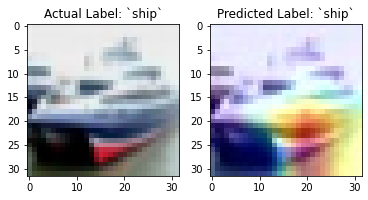

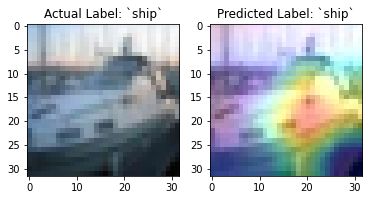

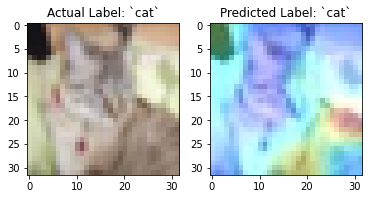

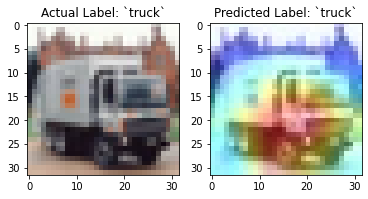

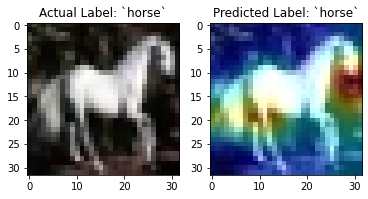

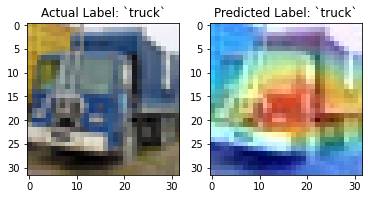

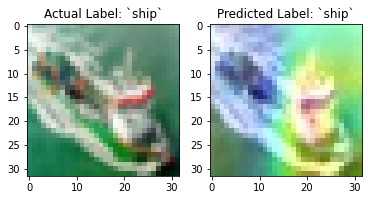

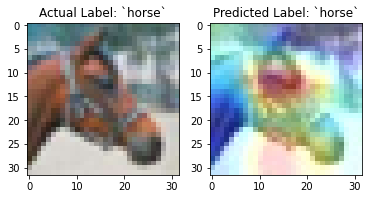

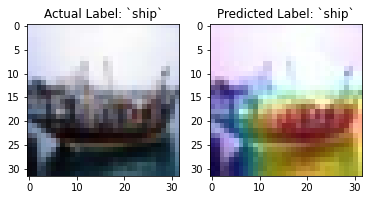

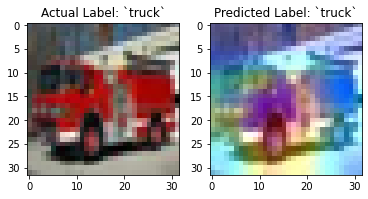

In [0]:
#display rightly predicted data
velasoka.show_gradcam_visualize(CIFAR10_LABELS, right_prediction)

# Visualizing GradCam Image (Wrong Prediction)

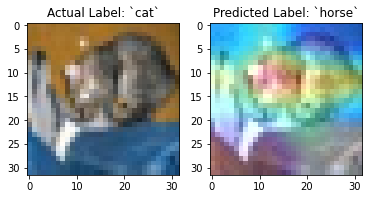

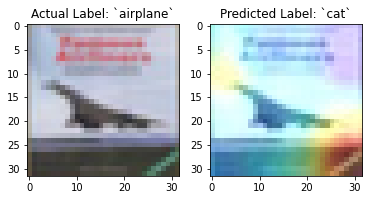

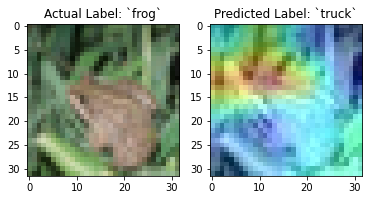

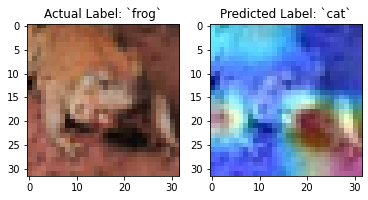

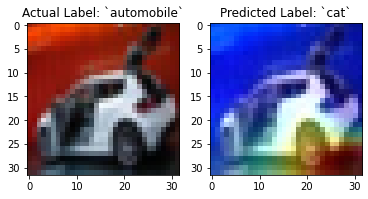

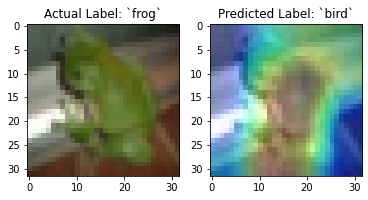

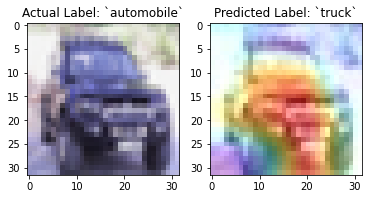

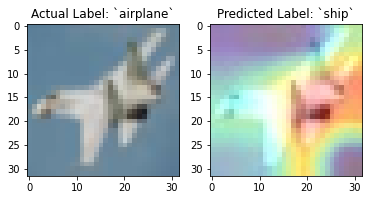

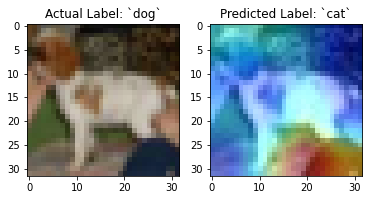

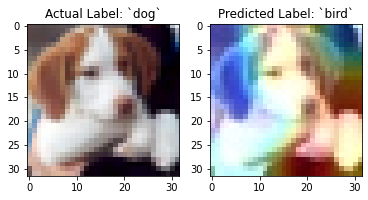

In [0]:
#display wrongly prediction data
velasoka.show_gradcam_visualize(CIFAR10_LABELS, wrong_prediction)

# Albumentation Transformation Training & Test Run 
* Result stored in resnet18-album.pt file and used to restore model



In [0]:
print("\nAlbumentations CNN Run\n---------------------------------------------------")
#albumentation CNN
velasoka.start_cnn(model=net, optimizer=optimizer, loss_fn=loss, data_loader=(album_train_dataloader, test_dataloader), device=device, epochs=25)

#save model
drive_file_path = velasoka.drive_path(folder="Session-9", filename="resnet18-album.pt")
velasoka.save_model(model=net, path=drive_file_path)

  0%|          | 0/12500 [00:00<?, ?it/s]


Albumentations CNN Run
---------------------------------------------------

EPOCH: 1


Training Batch=12499, loss=1.64190, Correct Prediction=24973/50000, Train Accuracy=49.94600: 100%|██████████| 12500/12500 [10:37<00:00, 19.61it/s]
Test Batch=2499, Correct Validation=6685/10000, Test Accuracy=66.85000: 100%|██████████| 2500/2500 [00:45<00:00, 54.37it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPOCH: 2


Training Batch=12499, loss=0.47874, Correct Prediction=35531/50000, Train Accuracy=71.06200: 100%|██████████| 12500/12500 [09:38<00:00, 21.28it/s]
Test Batch=2499, Correct Validation=7346/10000, Test Accuracy=73.46000: 100%|██████████| 2500/2500 [00:46<00:00, 57.20it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPOCH: 3


Training Batch=12499, loss=0.81082, Correct Prediction=39190/50000, Train Accuracy=78.38000: 100%|██████████| 12500/12500 [09:44<00:00, 21.38it/s]
Test Batch=2499, Correct Validation=7753/10000, Test Accuracy=77.53000: 100%|██████████| 2500/2500 [00:40<00:00, 61.70it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPOCH: 4


Training Batch=12499, loss=0.75056, Correct Prediction=41751/50000, Train Accuracy=83.50200: 100%|██████████| 12500/12500 [09:30<00:00, 21.92it/s]
Test Batch=2499, Correct Validation=8018/10000, Test Accuracy=80.18000: 100%|██████████| 2500/2500 [00:53<00:00, 50.85it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPOCH: 5


Training Batch=12499, loss=0.33930, Correct Prediction=43708/50000, Train Accuracy=87.41600: 100%|██████████| 12500/12500 [10:14<00:00, 20.33it/s]
Test Batch=2499, Correct Validation=8131/10000, Test Accuracy=81.31000: 100%|██████████| 2500/2500 [00:44<00:00, 55.80it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPOCH: 6


Training Batch=12499, loss=0.00105, Correct Prediction=45167/50000, Train Accuracy=90.33400: 100%|██████████| 12500/12500 [09:43<00:00, 21.44it/s]
Test Batch=2499, Correct Validation=8174/10000, Test Accuracy=81.74000: 100%|██████████| 2500/2500 [00:49<00:00, 51.00it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPOCH: 7


Training Batch=12499, loss=0.14463, Correct Prediction=46650/50000, Train Accuracy=93.30000: 100%|██████████| 12500/12500 [09:35<00:00, 22.31it/s]
Test Batch=2499, Correct Validation=8255/10000, Test Accuracy=82.55000: 100%|██████████| 2500/2500 [00:40<00:00, 56.96it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPOCH: 8


Training Batch=12499, loss=0.08496, Correct Prediction=47710/50000, Train Accuracy=95.42000: 100%|██████████| 12500/12500 [10:06<00:00, 20.61it/s]
Test Batch=2499, Correct Validation=8142/10000, Test Accuracy=81.42000: 100%|██████████| 2500/2500 [00:56<00:00, 44.08it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPOCH: 9


Training Batch=12499, loss=0.02122, Correct Prediction=48342/50000, Train Accuracy=96.68400: 100%|██████████| 12500/12500 [09:56<00:00, 20.97it/s]
Test Batch=2499, Correct Validation=8312/10000, Test Accuracy=83.12000: 100%|██████████| 2500/2500 [00:46<00:00, 54.25it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPOCH: 10


Training Batch=12499, loss=0.00216, Correct Prediction=48970/50000, Train Accuracy=97.94000: 100%|██████████| 12500/12500 [09:41<00:00, 21.50it/s]
Test Batch=2499, Correct Validation=8259/10000, Test Accuracy=82.59000: 100%|██████████| 2500/2500 [00:43<00:00, 58.07it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPOCH: 11


Training Batch=12499, loss=0.00146, Correct Prediction=49201/50000, Train Accuracy=98.40200: 100%|██████████| 12500/12500 [10:12<00:00, 20.39it/s]
Test Batch=2499, Correct Validation=8333/10000, Test Accuracy=83.33000: 100%|██████████| 2500/2500 [00:46<00:00, 54.16it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPOCH: 12


Training Batch=12499, loss=0.00031, Correct Prediction=49438/50000, Train Accuracy=98.87600: 100%|██████████| 12500/12500 [09:42<00:00, 21.45it/s]
Test Batch=2499, Correct Validation=8400/10000, Test Accuracy=84.00000: 100%|██████████| 2500/2500 [00:45<00:00, 54.38it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPOCH: 13


Training Batch=12499, loss=0.00771, Correct Prediction=49605/50000, Train Accuracy=99.21000: 100%|██████████| 12500/12500 [09:47<00:00, 22.38it/s]
Test Batch=2499, Correct Validation=8419/10000, Test Accuracy=84.19000: 100%|██████████| 2500/2500 [00:41<00:00, 64.04it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPOCH: 14


Training Batch=12499, loss=0.00091, Correct Prediction=49718/50000, Train Accuracy=99.43600: 100%|██████████| 12500/12500 [09:41<00:00, 21.51it/s]
Test Batch=2499, Correct Validation=8361/10000, Test Accuracy=83.61000: 100%|██████████| 2500/2500 [00:56<00:00, 46.39it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPOCH: 15


Training Batch=12499, loss=0.20244, Correct Prediction=49813/50000, Train Accuracy=99.62600: 100%|██████████| 12500/12500 [10:10<00:00, 21.26it/s]
Test Batch=2499, Correct Validation=8419/10000, Test Accuracy=84.19000: 100%|██████████| 2500/2500 [00:44<00:00, 56.31it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPOCH: 16


Training Batch=12499, loss=0.00002, Correct Prediction=49885/50000, Train Accuracy=99.77000: 100%|██████████| 12500/12500 [09:47<00:00, 21.27it/s]
Test Batch=2499, Correct Validation=8459/10000, Test Accuracy=84.59000: 100%|██████████| 2500/2500 [00:46<00:00, 53.24it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPOCH: 17


Training Batch=12499, loss=0.00290, Correct Prediction=49940/50000, Train Accuracy=99.88000: 100%|██████████| 12500/12500 [09:35<00:00, 22.05it/s]
Test Batch=2499, Correct Validation=8451/10000, Test Accuracy=84.51000: 100%|██████████| 2500/2500 [00:41<00:00, 60.51it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPOCH: 18


Training Batch=12499, loss=0.00005, Correct Prediction=49957/50000, Train Accuracy=99.91400: 100%|██████████| 12500/12500 [10:12<00:00, 19.99it/s]
Test Batch=2499, Correct Validation=8496/10000, Test Accuracy=84.96000: 100%|██████████| 2500/2500 [00:55<00:00, 44.74it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPOCH: 19


Training Batch=12499, loss=0.17082, Correct Prediction=49947/50000, Train Accuracy=99.89400: 100%|██████████| 12500/12500 [09:48<00:00, 21.25it/s]
Test Batch=2499, Correct Validation=8437/10000, Test Accuracy=84.37000: 100%|██████████| 2500/2500 [00:46<00:00, 53.46it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPOCH: 20


Training Batch=12499, loss=0.01080, Correct Prediction=49959/50000, Train Accuracy=99.91800: 100%|██████████| 12500/12500 [09:48<00:00, 21.23it/s]
Test Batch=2499, Correct Validation=8471/10000, Test Accuracy=84.71000: 100%|██████████| 2500/2500 [00:42<00:00, 59.19it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPOCH: 21


Training Batch=12499, loss=0.00001, Correct Prediction=49985/50000, Train Accuracy=99.97000: 100%|██████████| 12500/12500 [09:58<00:00, 20.24it/s]
Test Batch=2499, Correct Validation=8478/10000, Test Accuracy=84.78000: 100%|██████████| 2500/2500 [00:52<00:00, 42.80it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPOCH: 22


Training Batch=12499, loss=0.00530, Correct Prediction=49981/50000, Train Accuracy=99.96200: 100%|██████████| 12500/12500 [10:06<00:00, 20.62it/s]
Test Batch=2499, Correct Validation=8497/10000, Test Accuracy=84.97000: 100%|██████████| 2500/2500 [00:44<00:00, 55.56it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPOCH: 23


Training Batch=12499, loss=0.00007, Correct Prediction=49992/50000, Train Accuracy=99.98400: 100%|██████████| 12500/12500 [10:01<00:00, 20.78it/s]
Test Batch=2499, Correct Validation=8502/10000, Test Accuracy=85.02000: 100%|██████████| 2500/2500 [00:49<00:00, 50.32it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPOCH: 24


Training Batch=12499, loss=0.00099, Correct Prediction=49993/50000, Train Accuracy=99.98600: 100%|██████████| 12500/12500 [09:31<00:00, 21.30it/s]
Test Batch=2499, Correct Validation=8492/10000, Test Accuracy=84.92000: 100%|██████████| 2500/2500 [00:41<00:00, 60.05it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPOCH: 25


Training Batch=12499, loss=0.00054, Correct Prediction=49991/50000, Train Accuracy=99.98200: 100%|██████████| 12500/12500 [10:35<00:00, 19.67it/s]
Test Batch=2499, Correct Validation=8493/10000, Test Accuracy=84.93000: 100%|██████████| 2500/2500 [00:52<00:00, 48.08it/s]


AttributeError: ignored